# FarmVibes.AI Harvest Period

This notebook demonstrates how to infer germination and harvest periods based on NDVI timeseries. It makes use of an existing workflow that computes a NDVI timeseries for a given area.

To install the required packages, see [this README file](../README.md).

### Notebook outline
This notebook requires imagery data covering a complete crop season to run successfully. The user provides a geographical region and a date range of interest, which are input to a FarmVibes.AI workflow. The workflow consists of fetching Sentinel-2 data for the corresponding area and time, running cloud detection algorithms to obtain cloud-free imagery and computing daily NDVI indexes at 10m resolution. Then, it will fit a curve to the NDVI time series and estimate the start of the germination period and the end of the harvest period by looking for periods of small NDVI values and slight variations between successive observations.

Below are the main libraries used for this example and other useful links:
- [Shapely](https://github.com/shapely/shapely) is a library for manipulating geometric shapes.
- [Pandas](https://pandas.pydata.org/) is a library for manipulating tabular data.
- [LMFIT](https://lmfit.github.io/lmfit-py/) is a library for non-linear least-squares minimization and curve-fitting for python.

### Imports & Constants

In [1]:
# Utility imports
from datetime import datetime
from shapely import wkt
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from lmfit.models import SkewedGaussianModel

# FarmVibes.AI imports
from vibe_core.client import get_default_vibe_client

# FarmAI workflow name and description
WORKFLOW_NAME = "farm_ai/agriculture/ndvi_summary"
RUN_NAME = "ndvi summary"

### Generate the NDVI dataset with FarmVibes.AI platform

Let's define the region and the time range to consider for this task:
- **Region:** FarmVibes.AI platform expects a `.wkt` file with the polygon of the ROI (an example `input_region.wkt` is already provided, representing a field chosen at random in Iowa);
- **Time Range:** This notebook requires imagery data covering a complete crop season to run successfully. We define the range as a tuple with two datetimes (start and end dates). In the example below, we will analyze NDVI observations from 1st of April until the end of December.

In [2]:
input_geometry_path = "./input_region.wkt"
time_range = (datetime(2020, 4, 1), datetime(2020, 12, 30))

# Reading the geometry file 
with open(input_geometry_path) as f:
    geometry = wkt.load(f)

For the germination and harvest period task, we will run the `farm_ai/agriculture/ndvi_summary` workflow.
To build the dataset, we will instantiate the FarmVibes.AI remote client and run the workflow:

In [3]:
# Instantiate the client
client = get_default_vibe_client()

In [4]:
# Start the workflow
wf_run = client.run(WORKFLOW_NAME, RUN_NAME, geometry=geometry, time_range=time_range)

`wf_run` is a `VibeWorkflowRun` that holds the information about the workflow execution. A few of its important attributes:
- `wf_run.id`: the ID of the run
- `wf_run.status`: indicate the status of the run (pending, running, failed, or done)
- `wf_run.workflow`: the name of the workflow being executed (i.e., `WORKFLOW_NAME`)
- `wf_run.name`: the description provided by `RUN_NAME`
- `wf_run.output`: the dictionary with outputs produced by the workflow, indexed by sink names

In case you need to retrieve a previous workflow run, you can use `client.list_runs()` to list all existing executions and find the id of the desired run. It can be recovered by running `wf_run = client.get_run_by_id("ID-of-the-run")`.

We can also use the method `monitor` from `VibeWorkflowRun` to verify the progress of each op/inner workflow of our run.

In [5]:
wf_run.monitor()

Output()

Once finished, we can access the generated outputs through `wf_run.output`.

The list of outputs of the dataset generation workflow is:

In [6]:
wf_run.output.keys()

dict_keys(['timeseries'])

To access a specific output, we can do:

In [7]:
ndvi_timeseries = wf_run.output["timeseries"]

### Preprocess data
With the NDVI timeseries yielded by FarmVibes.AI, we will infer the germination and harvest periods by fitting a curve to the NDVI observations and the analyzing the difference between two sucessive days. There are two parameters in this section:

- `ndvi_threshold`: upper limit for NDVI at the beginning of germination and ending of harvest periods. Default: 0.15
- `delta_threshold`: upper limit for NDVI difference between successive observations. Default: 0.1

#### The next steps will:
- Load the CSV file in a Pandas dataframe
- Compute the day of the year from the observation date
- Fit a curve to the data using a Skewed Gaussian distribution
- Compute the NDVI difference between two successive days using the fitted curve
- Estimate the start of the germination period and the end of the harvest period by looking for periods of small NDVI values (smaller than **ndvi_threshold**) and slight variation between successive observations (df['delta_mean'] < **delta_threshold**). Obs.: select periods that provide at least ten measurements.

In [8]:
ndvi_threshold = 0.25
delta_threshold = 0.2

In [9]:
timeseries = wf_run.output["timeseries"]
df = pd.read_csv(timeseries[0].assets[0].path_or_url)
df['day_of_year'] = pd.to_datetime(df['date']).dt.day_of_year

In [10]:
x = df['day_of_year']
y = df['mean']

model = SkewedGaussianModel()
params = model.guess(y, x=x)
result = model.fit(y, params, x=x)

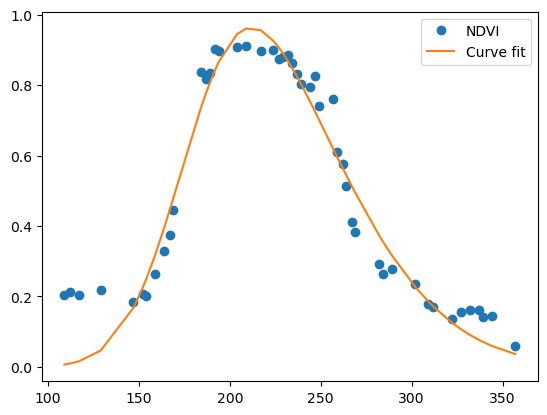

In [11]:
plt.plot(x, y, 'o', label='NDVI')
plt.plot(x, result.best_fit, '-', label='Curve fit')
plt.legend()
plt.show()

In [12]:
df['best_fit'] = result.best_fit
df['delta'] = df['best_fit'].diff()

In [13]:
df['in_germination'] = False
df['in_harvest'] = False

low_variance = df['delta'].abs() <= delta_threshold
low_ndvi = df['best_fit'] < ndvi_threshold
before_ndvi_peak = df['delta'] > 0
after_ndvi_peak = df['delta'] < 0

df.loc[low_ndvi & low_variance & before_ndvi_peak, 'in_germination'] = True
df.loc[low_ndvi & low_variance & after_ndvi_peak, 'in_harvest'] = True

In [14]:
g_min, g_max, g_mean = df[df['in_germination']]['day_of_year'].agg(['min', 'max', 'mean'])
h_min, h_max, h_mean = df[df['in_harvest']]['day_of_year'].agg(['min', 'max', 'mean'])

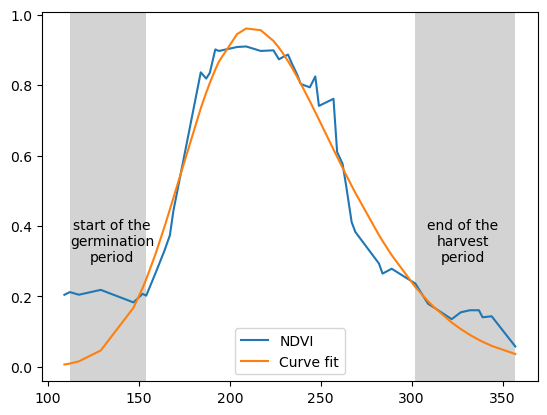

In [15]:
fig, ax = plt.subplots()
ax.plot(df['day_of_year'], df['mean'], label="NDVI")
ax.plot(df['day_of_year'], df['best_fit'], label="Curve fit")
ax.axvspan(g_min, g_max, facecolor='lightgrey')
ax.axvspan(h_min, h_max, facecolor='lightgrey')
ax.annotate('start of the\ngermination\nperiod', xy=(g_mean, 0.3), horizontalalignment='center')
ax.annotate('end of the\nharvest\nperiod', xy=(h_mean, 0.3), horizontalalignment='center')
plt.legend()
plt.show()